### 软间隔

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mean1, mean2 = np.array([0, 2]), np.array([2, 0])
covar = np.array([[1.5, 1.0], [1.0, 1.5]])
X1 = np.random.multivariate_normal(mean1, covar, 100)
y1 = np.ones(X1.shape[0])
X2 = np.random.multivariate_normal(mean2, covar, 100)
y2 = -1 * np.ones(X2.shape[0])
X_train = np.vstack((X1[:80], X2[:80]))
y_train = np.hstack((y1[:80], y2[:80]))
X_test = np.vstack((X1[80:], X2[80:]))
y_test = np.hstack((y1[80:], y2[80:]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(160, 2) (160,) (40, 2) (40,)


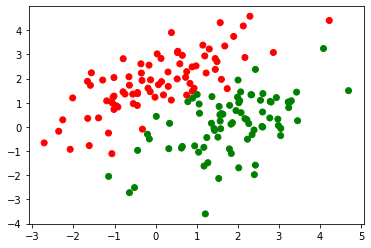

In [3]:
# 设置颜色参数
colors = {1:'r', -1:'g'}
# 绘制二分类数据集的散点图
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=pd.Series(y_train).map(colors))
plt.show();

In [4]:
### 定义一个线性核函数
def linear_kernel(x1, x2):
    '''
    输入:
    x1: 向量1
    x2: 向量2
    输出:
    np.dot(x1, x2): 两个向量的点乘
    '''
    return np.dot(x1, x2)

In [5]:
from cvxopt import matrix, solvers

### 定义近似线性可分支持向量机
### 软间隔最大化策略
class Soft_Margin_SVM:
    ### 定义基本参数
    def __init__(self, kernel=linear_kernel, C=None):
        # 软间隔svm核函数，默认为线性核函数
        self.kernel = kernel
        # 惩罚参数
        self.C = C
        if self.C is not None: 
            self.C = float(self.C)
    
    ### 定义线性支持向量机拟合方法
    def fit(self, X, y):
        # 训练样本数和特征数
        m, n = X.shape
        
        # 基于线性核计算Gram矩阵
        K = self._gram_matrix(X)
                
        # 初始化二次规划相关变量：P/q/G/h
        P = matrix(np.outer(y,y) * K)
        q = matrix(np.ones(m) * -1)
        A = matrix(y, (1, m))
        b = matrix(0.0)
        
        # 未设置惩罚参数时的G和h矩阵
        if self.C is None:
            G = matrix(np.diag(np.ones(m) * -1))
            h = matrix(np.zeros(m))
        # 设置惩罚参数时的G和h矩阵
        else:
            tmp1 = np.diag(np.ones(m) * -1)
            tmp2 = np.identity(m)
            G = matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(m)
            tmp2 = np.ones(m) * self.C
            h = matrix(np.hstack((tmp1, tmp2)))

        # 构建二次规划求解
        sol = solvers.qp(P, q, G, h, A, b)
        # 拉格朗日乘子
        a = np.ravel(sol['x'])

        # 寻找支持向量
        spv = a > 1e-5
        ix = np.arange(len(a))[spv]
        self.a = a[spv]
        self.spv = X[spv]
        self.spv_y = y[spv]
        print('{0} support vectors out of {1} points'.format(len(self.a), m))

        # 截距向量
        self.b = 0
        for i in range(len(self.a)):
            self.b += self.spv_y[i]
            self.b -= np.sum(self.a * self.spv_y * K[ix[i], spv])
        self.b /= len(self.a)

        # 权重向量
        self.w = np.zeros(n,)
        for i in range(len(self.a)):
            self.w += self.a[i] * self.spv_y[i] * self.spv[i]

    ### 定义Gram矩阵计算函数
    def _gram_matrix(self, X):
        m, n = X.shape
        K = np.zeros((m, m))
        # 遍历计算Gram矩阵
        for i in range(m):
            for j in range(m):
                K[i,j] = self.kernel(X[i], X[j])
        return K
    
    ### 定义映射函数
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
    
    ### 定义模型预测函数
    def predict(self, X):
        return np.sign(np.dot(self.w, X.T) + self.b)

In [6]:
from sklearn.metrics import accuracy_score
soft_margin_svm = Soft_Margin_SVM(C=0.1)
soft_margin_svm.fit(X_train, y_train)
y_pred = soft_margin_svm.predict(X_test)
# 计算测试集准确率
print('Accuracy of soft margin svm based on cvxopt: ', 
      accuracy_score(y_test, y_pred))

     pcost       dcost       gap    pres   dres
 0: -2.1727e+01 -2.7755e+01  8e+02  2e+01  8e-15
 1: -4.2352e+00 -2.5471e+01  7e+01  1e+00  9e-15
 2: -2.4248e+00 -1.1895e+01  1e+01  1e-01  2e-15
 3: -2.5376e+00 -4.0785e+00  2e+00  2e-02  2e-15
 4: -2.8720e+00 -3.3151e+00  5e-01  4e-03  1e-15
 5: -2.9677e+00 -3.1111e+00  2e-01  9e-04  1e-15
 6: -3.0021e+00 -3.0528e+00  5e-02  3e-04  1e-15
 7: -3.0196e+00 -3.0277e+00  8e-03  3e-05  1e-15
 8: -3.0219e+00 -3.0243e+00  2e-03  8e-07  1e-15
 9: -3.0230e+00 -3.0232e+00  2e-04  7e-08  1e-15
10: -3.0231e+00 -3.0231e+00  2e-06  7e-10  2e-15
Optimal solution found.
40 support vectors out of 160 points
Accuracy of soft margin svm based on cvxopt:  1.0


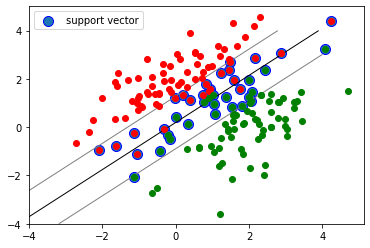

In [7]:
def plot_classifier(X1_train, X2_train, clf):
    plt.plot(X1_train[:,0], X1_train[:,1], "ro")
    plt.plot(X2_train[:,0], X2_train[:,1], "go")
    # plt.scatter(soft_margin_svm.spv[:,0], soft_margin_svm.spv[:,1], s=100, c="", edgecolors="b", label="support vector")
    plt.scatter(soft_margin_svm.spv[:,0], soft_margin_svm.spv[:,1], s=100, edgecolors="b", label="support vector")
    X1, X2 = np.meshgrid(np.linspace(-4,4,50), np.linspace(-4,4,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = soft_margin_svm.project(X).reshape(X1.shape)
    plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
    plt.legend()
    plt.show()
    
plot_classifier(X_train[y_train==1], X_train[y_train==-1], soft_margin_svm)

In [8]:
from sklearn import svm
# 创建svm模型实例
clf = svm.SVC(kernel='linear')
# 模型拟合
clf.fit(X_train, y_train)
# 模型预测
y_pred = clf.predict(X_test)
# 计算测试集准确率
print('Accuracy of soft margin svm based on sklearn: ', 
      accuracy_score(y_test, y_pred))

Accuracy of soft margin svm based on sklearn:  1.0
